In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import datetime
# from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.misc import factorial
plt.rcParams.update({'font.size': 16})

In [2]:
from glob import glob
from root_pandas import read_root

Welcome to JupyROOT 6.14/00


/home/nick/.local/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.4 is currently installed but you installed root_numpy against numpy 1.14.5. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [ ]:
import ROOT

#f = ROOT.TFile('mcc83_cosmic.root')
f = ROOT.TFile('/home/david/data/StopMuCalibration/stm_ana.root')
f.cd('stopmu')
print f
df = pd.DataFrame(tree2rec(f.Get('stopmu/reco_tree')))
print df.shape
df = df.query('_trk_start_z > 500. and _trk_end_z > 500.')
print df.shape

In [3]:
file_dir = "/home/nick/Desktop/MicroBooNE/StopMuCalibration/v07_07_03/stopmu_tag2/1102/prodgenie_bnb_nu_cosmic_uboone_mcc9.0_beta2_oct_reco_2d_wc_reco2/v1/*"
file_list = glob(file_dir+"/stopmu_ana.root")
# print(file_list)

In [4]:
save_folder = '/home/nick/Dropbox/MicroBooNE/_fig/18_11_05/stop_muons/'

In [89]:
columns = ['_run', '_sub', '_evt', '_trk_len', '_trk_start_x', '_trk_start_y',
       '_trk_start_z', '_trk_end_x', '_trk_end_y', '_trk_end_z',
       '_yz_true_reco_distance', '_yz_trackid', '_matchtrackid', '_matchscore',
       '_pitch_u', '_pitch_v', '_pitch_y', '_dqdx_y', '_dqdx_tm_y', '_rr_y',
       '_delta_t_closest_flash']
selection = '_trk_len > 50'
df = read_root(file_list[:100], key="stopmu/reco_tree", where=selection)
print(df.shape)

(163451, 27)


In [ ]:
df.columns

In [ ]:
df.dropna(inplace=True)

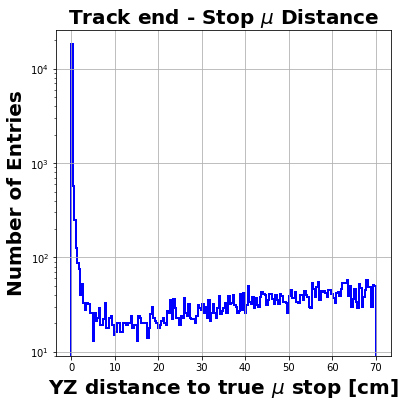

In [74]:
fig = plt.figure(figsize=(6,6))
BINS = np.linspace(0,70,201)
plt.hist(df['_yz_true_reco_distance'].values,bins=BINS,histtype='step',color='b',lw=2)
plt.grid()
plt.yscale('log')
plt.title('Track end - Stop $\mu$ Distance',fontsize=20,fontweight='bold')
plt.xlabel('YZ distance to true $\mu$ stop [cm]',fontsize=20,fontweight='bold')
plt.ylabel('Number of Entries',fontsize=20,fontweight='bold')
#plt.ylim([20,4000])
plt.savefig(save_folder + 'yz_distance.png', dpi=500)
plt.show()

In [75]:
def GetMIPFit(x):
    
    dqdx_v = x['_dqdx_tm_y']
    rr_v   = x['_rr_y']
    
    rr_max = x['_trk_len']
    
    if (rr_max < 150.): return -1,-1
    
    rr_MIP_idx_v = np.where((rr_v > 100) & (rr_v < 150))[0]
    if (len(rr_MIP_idx_v) == 0): return -1,-1
    dqdx_MIP_v = [dqdx_v[i] for i in rr_MIP_idx_v]
    avg = np.average(dqdx_MIP_v)
    rms = np.std(dqdx_MIP_v)
    return avg,rms

def BraggArea(x,rmin,rmax):

    dqdx_v = x['_dqdx_tm_y']
    rr_v   = x['_rr_y']
    mip    = x['mip']
    
        
    if (mip < 0): return -1
    
    rr_BRAGG_idx_v = np.where((rr_v < rmax) & (rr_v > rmin))[0]
    area = 0
    for i in rr_BRAGG_idx_v:
        if (i < len(rr_v)-1):
            ampl = (dqdx_v[i]-mip)
            area += ampl * np.abs(rr_v[i]-rr_v[i+1])
            #print '+= ampl = %.02f \t\t dr = %.02f'%(ampl,np.abs(rr_v[i]-rr_v[i+1]))
    return area/mip

def dQfit(x,a,b,c):
    return a*x**2 + b*x + c

def MIPfit(x):
    
    dqdx_v = x['_dqdx_tm_y']
    rr_v   = x['_rr_y']
    mip    = x['mip']
    
    dqdx_v = dqdx_v.astype(float)
    rr_v   = rr_v.astype(float)
    
    if (len(rr_v) < 50):
        return -1
    
    rr_v_fit = []
    dqdx_trunc_v_fit = []
    for i,r in enumerate(rr_v):
        if (r < 50):
            rr_v_fit.append(r)
            dqdx_trunc_v_fit.append(dqdx_v[i]/mip)
    
    try:
        popt,popv = curve_fit(dQfit,rr_v_fit,dqdx_trunc_v_fit)
        return popt[2]
    except:
        return -1

In [76]:
df['mip']    = df.apply(lambda x : GetMIPFit(x)[0], axis=1)
df['miperr'] = df.apply(lambda x : GetMIPFit(x)[1], axis=1)

In [77]:
df['mipfit'] = df.apply(lambda x : MIPfit(x), axis=1)

/home/nick/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [78]:
df['BA_000_050'] = df.apply(lambda x : BraggArea(x,0,50), axis=1)
df['BA_050_100'] = df.apply(lambda x : BraggArea(x,50,100), axis=1)

In [79]:
df = df.query('BA_000_050 != -1 and BA_050_100 != -1')

In [80]:
dfstop = df.query('0 < _yz_true_reco_distance < 3') # cut that defines what is a true stopping muon

In [81]:
df.dropna(inplace=True) 
dfstop.dropna(inplace=True) 

/home/nick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/home/nick/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


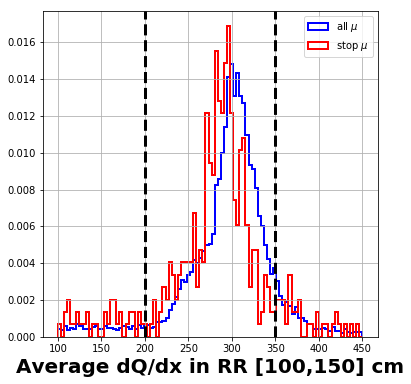

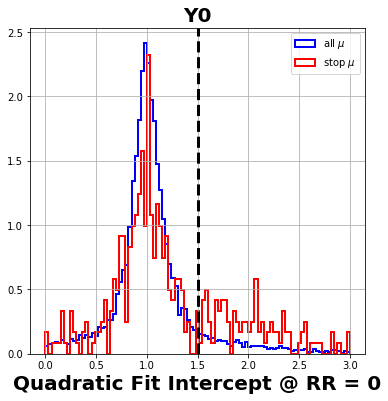

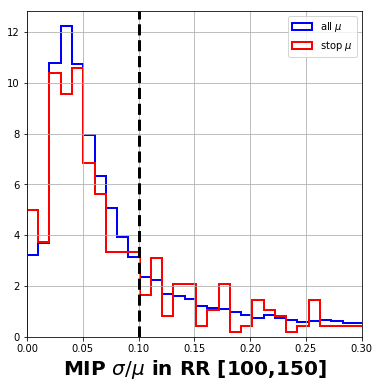

In [82]:
fig = plt.figure(figsize=(6,6))
plt.hist(df['mip'].values    ,bins=np.linspace(100,450,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['mip'].values,bins=np.linspace(100,450,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('Average dQ/dx in RR [100,150] cm',fontsize=20,fontweight='bold')
plt.axvline(200,color='k',linestyle='--',lw=3)
plt.axvline(350,color='k',linestyle='--',lw=3)
plt.grid()
plt.legend(loc=1)
plt.savefig(save_folder+'averagedqdx.png', dpi=500)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['mipfit'].values    ,bins=np.linspace(0,3,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['mipfit'].values,bins=np.linspace(0,3,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('Quadratic Fit Intercept @ RR = 0',fontsize=20,fontweight='bold')
plt.title('Y0',fontsize=20,fontweight='bold')
plt.axvline(1.5,color='k',linestyle='--',lw=3)
plt.grid()
plt.legend(loc=1)
plt.savefig(save_folder+'quadratic_fit_intercept.png', dpi=500)
plt.show()

mipeA = df['miperr'].values / df['mip'].values
mipeS = dfstop['miperr'].values / dfstop['mip'].values

fig = plt.figure(figsize=(6,6))
plt.hist(mipeA ,bins=np.linspace(0,1,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(mipeS,bins=np.linspace(0,1,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('MIP $\sigma/\mu$ in RR [100,150]',fontsize=20,fontweight='bold')

plt.axvline(0.1,color='k',linestyle='--',lw=3)
plt.xlim([0,0.3])
plt.grid()
plt.legend(loc=1)
plt.savefig(save_folder+'mip_sigma_mu.png', dpi=500)
plt.show()

/home/nick/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


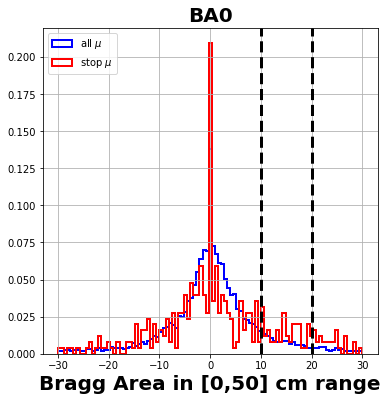

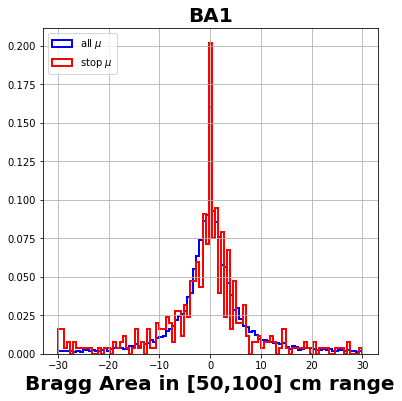

In [83]:
fig = plt.figure(figsize=(6,6))
plt.hist(df['BA_000_050'].values    ,bins=np.linspace(-30,30,100)\
         ,histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['BA_000_050'].values,bins=np.linspace(-30,30,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('Bragg Area in [0,50] cm range',fontsize=20,fontweight='bold')
plt.title('BA0',fontsize=20,fontweight='bold')
plt.axvline(10,color='k',linestyle='--',lw=3)
plt.axvline(20,color='k',linestyle='--',lw=3)
plt.grid()
plt.legend(loc=2)
plt.savefig(save_folder + 'bragg_area_0_50.png', dpi=500)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['BA_050_100'].values    ,bins=np.linspace(-30,30,100),\
         histtype='step',lw=2,color='b',normed=True,label='all $\mu$')
plt.hist(dfstop['BA_050_100'].values,bins=np.linspace(-30,30,100),\
         histtype='step',lw=2,color='r',normed=True,label='stop $\mu$')
plt.xlabel('Bragg Area in [50,100] cm range',fontsize=20,fontweight='bold')
plt.title('BA1',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=2)
#plt.ylim([0,300])
plt.savefig(save_folder + 'bragg_area_50_100.png', dpi=500)
plt.show()

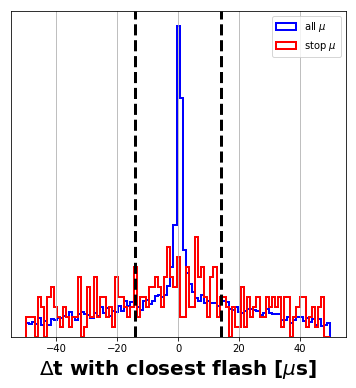

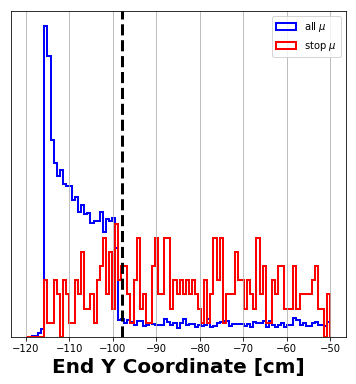

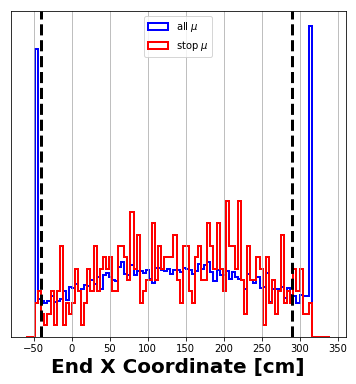

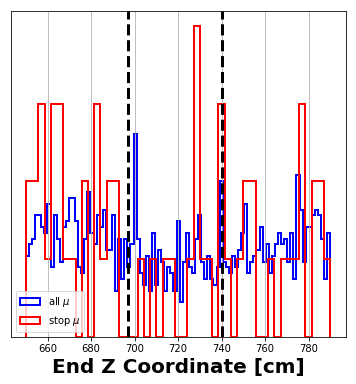

In [84]:
TMAX = 50

fig = plt.figure(figsize=(6,6))
plt.hist(df['_delta_t_closest_flash'].values    ,bins=np.linspace(-TMAX,TMAX,100),\
         histtype='step',lw=2,color='b',density=True,label='all $\mu$')
plt.hist(dfstop['_delta_t_closest_flash'].values,bins=np.linspace(-TMAX,TMAX,100),\
         histtype='step',lw=2,color='r',density=True,label='stop $\mu$')
plt.xlabel('$\Delta$t with closest flash [$\mu$s]',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=1)
plt.axvline(14,color='k',linestyle='--',lw=3)
plt.axvline(-14,color='k',linestyle='--',lw=3)
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig(save_folder + 'delta_t.png', dpi=500)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['_trk_end_y'].values    ,bins=np.linspace(-120,-50,100),\
         histtype='step',lw=2,color='b',density=True,label='all $\mu$')
plt.hist(dfstop['_trk_end_y'].values,bins=np.linspace(-120,-50,100),\
         histtype='step',lw=2,color='r',density=True,label='stop $\mu$')
plt.xlabel('End Y Coordinate [cm]',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=1)
plt.axvline(-98,color='k',linestyle='--',lw=3)
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig(save_folder + 'end_y.png', dpi=500)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['_trk_end_x'].values    ,bins=np.linspace(-60,340,100),\
         histtype='step',lw=2,color='b',density=True,label='all $\mu$')
plt.hist(dfstop['_trk_end_x'].values,bins=np.linspace(-60,340,100),\
         histtype='step',lw=2,color='r',density=True,label='stop $\mu$')
plt.xlabel('End X Coordinate [cm]',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=9)
plt.axvline(-40,color='k',linestyle='--',lw=3)
plt.axvline(290,color='k',linestyle='--',lw=3)
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig(save_folder + 'end_x.png', dpi=500)
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist(df['_trk_end_z'].values    ,bins=np.linspace(650,790,100),\
         histtype='step',lw=2,color='b',density=True,label='all $\mu$')
plt.hist(dfstop['_trk_end_z'].values,bins=np.linspace(650,790,50),\
         histtype='step',lw=2,color='r',density=True,label='stop $\mu$')
plt.xlabel('End Z Coordinate [cm]',fontsize=20,fontweight='bold')
plt.grid()
plt.legend(loc=3)
plt.axvline(697,color='k',linestyle='--',lw=3)
plt.axvline(740,color='k',linestyle='--',lw=3)
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig(save_folder + 'end_z.png', dpi=500)
plt.show()

In [85]:
print(df.shape[0])

# study impact of cuts
cut_v = ['BA_000_050 != -1 and BA_050_100 != -1',\
         '_trk_end_y > -98',\
         #'_px < 0',\
         '_trk_end_z < 697 or _trk_end_z > 742',\
         '_trk_end_x > -40 and _trk_end_x < 290',\
         '_trk_end_z > 10 and _trk_end_z < 1020.',\
         'abs(_delta_t_closest_flash) > 14',\
         #'mip > 200 and mip < 350',\
         'BA_000_050 > 10 and BA_000_050 < 20',\
         #'BA_050_100 < 10',\
         #'miperr/mip < 0.1',\
         'mipfit > 1.5 and mipfit < 2.0',\
         '_trk_len > 150'
         ]

dfcuts = df
dfgood = df.query('_yz_true_reco_distance < 5.')

for cut in cut_v:
    dfcuts = dfcuts.query(cut)
    allmu  = dfcuts.shape[0]
    dfgood = dfgood.query(cut)
    stpmu  = dfgood.shape[0]
    eff    = stpmu/19000.
    print('cut %40s : all = %05i ... stop = %05i ... purity = %.03f ... eff = %.02f'%
    (cut,allmu,stpmu,100*float(stpmu)/float(allmu),eff))
    
    
stop_res_v = np.linspace(0,15,16)
purity_v = []
purity_e = []

for res in stop_res_v:
    
    dfgood = df.query('_yz_true_reco_distance < %f'%res)

    for cut in cut_v:
        dfcuts = dfcuts.query(cut)
        dfgood = dfgood.query(cut)
        
    allmu = dfcuts.shape[0]
    stopmu = dfgood.shape[0]
    
    p = float(stopmu)/float(allmu)
    error = np.sqrt(p*(1-p)/float(allmu))
    
    purity_v.append(p)
    purity_e.append(error)

13920
cut    BA_000_050 != -1 and BA_050_100 != -1 : all = 13920 ... stop = 00548 ... purity = 3.937 ... eff = 0.03
cut                         _trk_end_y > -98 : all = 04790 ... stop = 00450 ... purity = 9.395 ... eff = 0.02
cut     _trk_end_z < 697 or _trk_end_z > 742 : all = 04619 ... stop = 00438 ... purity = 9.483 ... eff = 0.02
cut    _trk_end_x > -40 and _trk_end_x < 290 : all = 03106 ... stop = 00404 ... purity = 13.007 ... eff = 0.02
cut   _trk_end_z > 10 and _trk_end_z < 1020. : all = 02658 ... stop = 00401 ... purity = 15.087 ... eff = 0.02
cut         abs(_delta_t_closest_flash) > 14 : all = 00628 ... stop = 00277 ... purity = 44.108 ... eff = 0.01
cut      BA_000_050 > 10 and BA_000_050 < 20 : all = 00085 ... stop = 00032 ... purity = 37.647 ... eff = 0.00
cut            mipfit > 1.5 and mipfit < 2.0 : all = 00028 ... stop = 00012 ... purity = 42.857 ... eff = 0.00
cut                           _trk_len > 150 : all = 00028 ... stop = 00012 ... purity = 42.857 ... eff = 0.0

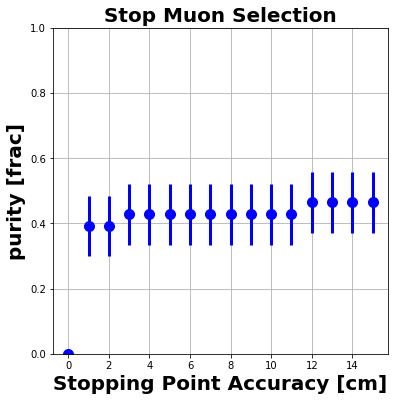

In [86]:
fig = plt.figure(figsize=(6,6))
plt.errorbar(stop_res_v,purity_v,yerr=purity_e,fmt='bo',markersize=10,lw=3)
plt.grid()
plt.ylim([0.,1.0])
plt.xlabel('Stopping Point Accuracy [cm]',fontsize=20,fontweight='bold')
plt.ylabel('purity [frac]',fontsize=20,fontweight='bold')
plt.title('Stop Muon Selection',fontsize=20,fontweight='bold')
plt.savefig(save_folder + 'purity.png', dpi=500)
plt.show()

In [87]:
rr_cumulative_v   = []
dqdx_cumulative_v = []
dqdx_trunc_cumulative_v = []
pitch_cumulative_v = []
pz_cumulative_v = []
py_cumulative_v = []
px_cumulative_v = []

poly_0 = []
dmin_v = []

for idx, entry in dfcuts.iterrows():
    
    rr_v   = np.array(entry['_rr_y'])
    dqdx_v = np.array(entry['_dqdx_y'])
    dqdx_trunc_v = np.array(entry['_dqdx_tm_y'])
#     pz = entry['_pz']
#     py = entry['_py']
#     px = entry['_px']
#     pitch = 0.3/np.abs(pz)
    pitch = entry['_pitch_y']
    
    
    for dqdx in dqdx_v:
        dqdx_cumulative_v.append(dqdx)
    for dqdx in dqdx_trunc_v:
        dqdx_trunc_cumulative_v.append(dqdx)
    for rr in rr_v:
        rr_cumulative_v.append(rr)
        pitch_cumulative_v.append(pitch)
#         px_cumulative_v.append(px)
#         py_cumulative_v.append(py)
#         pz_cumulative_v.append(pz)

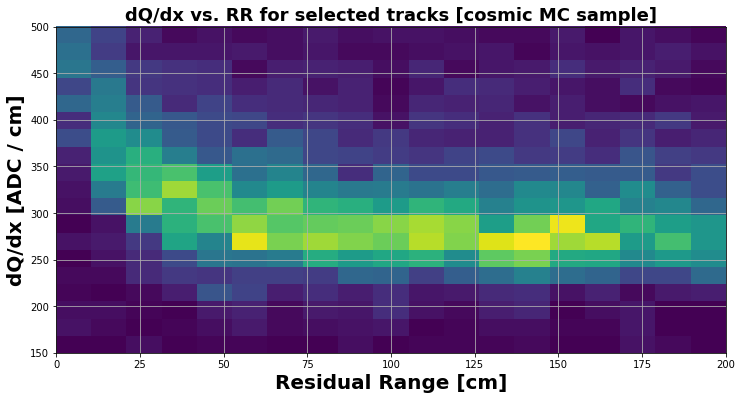

In [88]:
fig = plt.figure(figsize=(12,6))
BINS = ( np.linspace(0,200,20), np.linspace(150,500,20) )
plt.hist2d(rr_cumulative_v,dqdx_cumulative_v,bins=BINS)
plt.xlabel('Residual Range [cm]',fontsize=20,fontweight='bold')
plt.ylabel('dQ/dx [ADC / cm]',fontsize=20,fontweight='bold')
plt.title('dQ/dx vs. RR for selected tracks [cosmic MC sample]',fontweight='bold',fontsize=18)
plt.grid()
plt.savefig(save_folder + 'dqdx_residual_range.png', dpi=500)
plt.show()

In [ ]:
# save to picke file:
fout = open('stopmu_mcc83.csv','wb')

for i,rr in enumerate(rr_cumulative_v):
    px = px_cumulative_v[i]
    py = py_cumulative_v[i]
    pz = pz_cumulative_v[i]
    fout.write('%.02f \t %.02f \t %.02f \t %.02f \t %.02f \t %.02f \n'%\
               (rr,dqdx_cumulative_v[i],pitch_cumulative_v[i],px,py,pz))
    
fout.close()

In [ ]:
# VALIDATE RANGE vs. CALORIMETRY ENERGY

In [26]:
# invert Recombination Modified Box Model to get dE/dx from dQ/dx

# argon density [g/cm^3]
rho = 1.396
# electric field [kV/cm]
efield = 0.273
# ionization energy [MeV/e-]
Wion = 23.6*(10**(-6))

fModBoxA = 0.93
fModBoxB = 0.562

def ModBoxInverse(dqdx):
    dedx = (np.exp(fModBoxB * Wion * dqdx ) - fModBoxA) / fModBoxB
    return dedx   

/home/nick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/home/nick/.local/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2752: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.844227e-17
  p = scipy.linalg.solve(Q, tmp)
/home/nick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


200.18270394585397


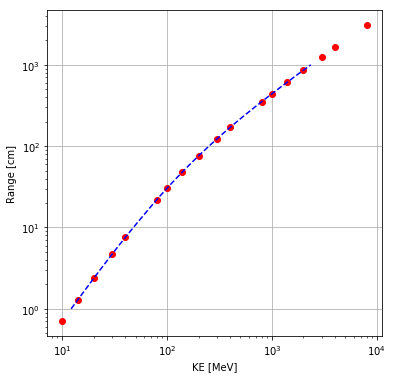

In [46]:
from scipy.interpolate import spline

pdg_rr_v = []
pdg_dedx_v = []
pdg_ke_v = []
pdg_rr_fit_v = []
pdg_dedx_fit_v = []
pdg_ke_fit_v = []

fin = open('mutable.txt')
rho = 1.396

for line in fin:
    words = line.split()
    pdg_rr_v.append(   float(words[-1])/rho )
    pdg_dedx_v.append( float(words[2]) *rho )
    pdg_ke_v.append(   float(words[0])      )


pdg_rr_fit_v   = np.linspace(1,1000,10000)
pdg_dedx_fit_v = spline(pdg_rr_v,pdg_dedx_v,pdg_rr_fit_v)
pdg_ke_fit_v = spline(pdg_rr_v,pdg_ke_v,pdg_rr_fit_v)


# fiven a RR value, get the energy
def ERange(RR):
    for i in range(len(pdg_rr_fit_v)):
        if (RR <= pdg_rr_fit_v[i]):
            return pdg_ke_fit_v[i]              
    return -1

print(ERange(76.14))

fig = plt.figure(figsize=(6,6))
plt.plot(pdg_ke_v,pdg_rr_v,'ro')
plt.grid()
plt.plot(pdg_ke_fit_v,pdg_rr_fit_v,'b--')
# plt.xlim([180,220])
# plt.ylim([70,80])
plt.xlabel('KE [MeV]')
plt.ylabel('Range [cm]')
plt.xscale('log')
plt.yscale('log')
plt.savefig(save_folder+'spline.png', dpi=500)
plt.show()

In [ ]:
def Pitch(x):
    return 0.3/np.abs(x['_pz'])

dfcuts['pitch'] = dfcuts.apply(lambda x : Pitch(x),axis=1)

In [40]:
def Energy(x,elecgain):
    energy = 0.
    dqdx_v = x['_dqdx_y']
    rr_v   = x['_rr_y']
    for i in range(1,len(dqdx_v)):
        dqdx = dqdx_v[i]
        drr  = np.abs(rr_v[i-1]-rr_v[i])
        dedx = ModBoxInverse(dqdx*elecgain)
        energy += drr * dedx
    energy += (np.abs(rr_v[0]-rr_v[1])) * ModBoxInverse(dqdx_v[0]*elecgain)
    return energy

dfcuts['energy'] = dfcuts.apply(lambda x : Energy(x,200.), axis=1)

In [41]:
def EnergyfromRange(x):
    rrmax = np.max(x['_rr_v'])
    return ERange(rrmax)
dfcuts['erange'] = dfcuts.apply(lambda x : EnergyfromRange(x),axis=1)

In [42]:
def gauss(x,mu,sigma,A):
    return A * (1./np.sqrt(np.pi*2*sigma*sigma)  * np.exp(-((x-mu)**2)/(2*sigma*sigma) ))

In [43]:
NSKIP = 35

In [44]:
fig = plt.figure(figsize=(6,6))
BINS = (np.linspace(200,800,50),np.linspace(200,800,50))
plt.hist2d(dfcuts['_energy_mc'].values-105.,dfcuts['energy'].values,bins=BINS)
plt.grid()
plt.ylabel('Calorimetry Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlabel('Truth Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlim([300,800])
plt.ylim([300,800])
plt.show()

dfratio = dfcuts.query('energy/erange > 0.5 and energy/erange < 1.5')
frac_v = dfratio['energy'].values/dfratio['erange'].values

vals,bine = np.histogram(frac_v,bins=np.linspace(0.5,1.5,100))
binc = 0.5*(bine[1:]+bine[:-1])
popt,popv = curve_fit(gauss,binc[NSKIP:-NSKIP],vals[NSKIP:-NSKIP],p0=[1.0,0.1,np.sum(vals)])
xvals = np.linspace(binc[NSKIP],binc[-NSKIP],1000)

fig = plt.figure(figsize=(6,6))
plt.plot(xvals,gauss(xvals,*popt),'r--',lw=3,label='$\mu$ = %.02f $\sigma$ = %.02f'%(popt[0],popt[1]))
plt.errorbar(binc,vals,yerr=np.sqrt(vals),fmt='bo',lw=2,markersize=8)
#plt.hist(frac_v,bins=np.linspace(0.7,1.3,50),histtype='step',lw=2)
plt.xlim([0.5,1.5])
plt.ylim([0,np.max(vals)*1.3])
plt.grid()
plt.legend()
plt.ylabel('Number of Tracks',fontsize=20,fontweight='bold')
plt.xlabel('Calorimetry Energy / Truth Energy',fontsize=20,fontweight='bold')
plt.show()

KeyError: '_energy_mc'

<Figure size 432x432 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(6,6))
BINS = (np.linspace(200,800,50),np.linspace(200,800,50))
plt.hist2d(dfcuts['_energy_mc'].values-105.,dfcuts['erange'].values,bins=BINS)
plt.grid()
plt.ylabel('Range Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlabel('Truth Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlim([300,800])
plt.ylim([300,800])
plt.show()

fig = plt.figure(figsize=(6,6))
dfratio = dfcuts.query('erange/_energy_mc > 0 and erange/_energy_mc < 1.5')
frac_v = dfratio['erange'].values/(dfratio['_energy_mc'].values-105.)

vals,bine = np.histogram(frac_v,bins=np.linspace(0.5,1.5,100))
binc = 0.5*(bine[1:]+bine[:-1])
popt,popv = curve_fit(gauss,binc[NSKIP:-NSKIP],vals[NSKIP:-NSKIP],p0=[1.0,0.1,np.sum(vals)])
xvals = np.linspace(binc[NSKIP],binc[-NSKIP],1000)

fig = plt.figure(figsize=(6,6))
plt.plot(xvals,gauss(xvals,*popt),'r--',lw=3,label='$\mu$ = %.02f $\sigma$ = %.02f'%(popt[0],popt[1]))
plt.errorbar(binc,vals,yerr=np.sqrt(vals),fmt='bo',lw=2,markersize=8)
#plt.hist(frac_v,bins=np.linspace(0.7,1.3,50),histtype='step',lw=2)
plt.xlim([0.5,1.5])
plt.ylim([0,np.max(vals)*1.3])
plt.grid()
plt.legend()
plt.ylabel('Number of Tracks',fontsize=20,fontweight='bold')
plt.xlabel('Range Energy / Truth Energy',fontsize=20,fontweight='bold')
plt.show()

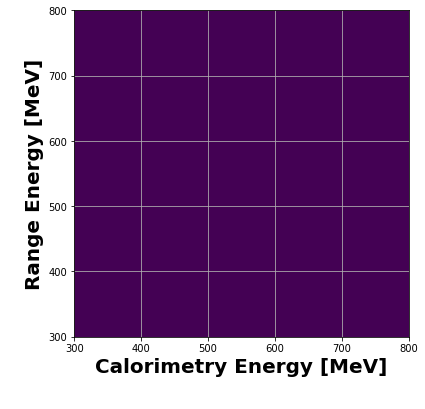

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

<Figure size 432x432 with 0 Axes>

In [45]:
fig = plt.figure(figsize=(6,6))
BINS = (np.linspace(200,800,50),np.linspace(200,800,50))
plt.hist2d(dfcuts['erange'].values,dfcuts['energy'].values,bins=BINS)
plt.grid()
plt.ylabel('Range Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlabel('Calorimetry Energy [MeV]',fontsize=20,fontweight='bold')
plt.xlim([300,800])
plt.ylim([300,800])
plt.show()

fig = plt.figure(figsize=(6,6))
#dfratio = dfcuts.query('energy/_energy_mc > 0 and energy/_energy_mc < 1.5')
frac_v = dfcuts['energy'].values/dfcuts['erange'].values


vals,bine = np.histogram(frac_v,bins=np.linspace(0.5,1.5,100))
binc = 0.5*(bine[1:]+bine[:-1])
popt,popv = curve_fit(gauss,binc[NSKIP:-NSKIP],vals[NSKIP:-NSKIP],p0=[1.0,0.1,np.sum(vals)])
xvals = np.linspace(binc[NSKIP],binc[-NSKIP],1000)

fig = plt.figure(figsize=(6,6))
plt.plot(xvals,gauss(xvals,*popt),'r--',lw=3,label='$\mu$ = %.02f $\sigma$ = %.02f'%(popt[0],popt[1]))
plt.errorbar(binc,vals,yerr=np.sqrt(vals),fmt='bo',lw=2,markersize=8)
#plt.hist(frac_v,bins=np.linspace(0.7,1.3,50),histtype='step',lw=2)
plt.xlim([0.5,1.5])
plt.ylim([0,np.max(vals)*1.3])
plt.grid()
plt.legend()
plt.ylabel('Number of Tracks',fontsize=20,fontweight='bold')
plt.xlabel('Calorimetry Energy / Range Energy',fontsize=20,fontweight='bold')
plt.show()